In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import UnivariateSpline

#Inintial Hypothesis
#1. Is there any seasonality in number of customers using the cab service?
#2. Is there a sales difference between companies?
#3. Is there a difference in sales between the cities?
#4. Is there a difference in sales between the years?
#5. Is there a certain age group that uses the cab service more than others?

In [2]:
def percentile_summary(df, column_name="x"):
  percentiles = [0.2, 0.4, 0.6, 0.8]
  for p in percentiles:
    threshold = df[column_name].quantile(p)
    count = df[column_name][df[column_name] > threshold].count()
    pct = f"{count / len(df) * 100:.1f}%"
    print(f"x>{threshold:.0f} = {pct}")

def detectandDropOutliers(df, numerical_column):
  for column in numerical_column:
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    lower_bound = df[column].quantile(0.25) - 1.5 * IQR
    upper_bound = df[column].quantile(0.75) + 1.5 * IQR
    outlier_count = (df[column] < lower_bound).sum() + (df[column] > upper_bound).sum()
    print(f"Outliers in column {column}: {outlier_count}\n")
    df = df[df[column] < upper_bound]

  return df

In [3]:
Cab_Data = pd.read_csv('Cab_Data.csv')
City = pd.read_csv('City.csv')
Customer_ID = pd.read_csv('Customer_ID.csv')
Transaction_ID = pd.read_csv('Transaction_ID.csv')

In [4]:
print("Transaction_ID")
print("\nhead")
print(Transaction_ID.head())
print("\nshape")
print(Transaction_ID.shape)
print("\ndescribe")
print(Transaction_ID.describe())
print("\nisnull sum")
print(Transaction_ID.isnull().sum())
print("\nduplicated sum")
print(Transaction_ID.duplicated().sum())

#Transaction ID specific analysis
#no need for outlier detection
print("\n\nTransaction ID specific analysis")
print(Transaction_ID['Payment_Mode'].value_counts(normalize=True))


Transaction_ID

head
   Transaction ID  Customer ID Payment_Mode
0        10000011        29290         Card
1        10000012        27703         Card
2        10000013        28712         Cash
3        10000014        28020         Cash
4        10000015        27182         Card

shape
(440098, 3)

describe
       Transaction ID    Customer ID
count    4.400980e+05  440098.000000
mean     1.022006e+07   23619.513120
std      1.270455e+05   21195.549816
min      1.000001e+07       1.000000
25%      1.011004e+07    3530.000000
50%      1.022006e+07   15168.000000
75%      1.033008e+07   43884.000000
max      1.044011e+07   60000.000000

isnull sum
Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64

duplicated sum
0


Transaction ID specific analysis
Payment_Mode
Card    0.599846
Cash    0.400154
Name: proportion, dtype: float64


In [5]:
print("\n\nCab_Data")
print("head")
print(Cab_Data.head())
print("\nshape")
print(Cab_Data.shape)
print("\ndescribe")
print(Cab_Data.describe())
print("\nisnull sum")
print(Cab_Data.isnull().sum())
print("\nduplicated sum")
print(Cab_Data.duplicated().sum())


# Cab Data specific analysis

# Number to date using (datetime.date(1900, 1, 1) + datetime.timedelta(days=43102)) for each row in Date of Travel (ENABLE ONCE ONLY, after that comment out) 
Cab_Data['Date of Travel'] = Cab_Data['Date of Travel'].apply(lambda x: (datetime.date(1900, 1, 1) + datetime.timedelta(days=x)).strftime("%d-%m-%Y"))

# Creating seperate DataFrames for pink and yellow cab data
yellow_cab_data = Cab_Data[Cab_Data["Company"] == "Yellow Cab"]
pink_cab_data = Cab_Data[Cab_Data["Company"] == "Pink Cab"]

pink_cab_data['Profit'] = pink_cab_data['Price Charged'] - pink_cab_data['Cost of Trip']
yellow_cab_data['Profit'] = yellow_cab_data['Price Charged'] - yellow_cab_data['Cost of Trip']

yellow_cab_data['Price_per_KM'] = yellow_cab_data["Price Charged"] / yellow_cab_data['KM Travelled']
pink_cab_data['Price_per_KM'] = pink_cab_data["Price Charged"] / pink_cab_data['KM Travelled']

yellow_cab_data['Profit_per_KM'] = yellow_cab_data["Profit"] / yellow_cab_data['KM Travelled']
pink_cab_data['Profit_per_KM'] = pink_cab_data["Profit"]  / pink_cab_data['KM Travelled']

print("\noutliers")
yellow_cab_data = detectandDropOutliers(yellow_cab_data, ["Price Charged", "Cost of Trip"])
pink_cab_data = detectandDropOutliers(pink_cab_data, ["Price Charged", "Cost of Trip"])

print("\n\nPink Cab")
print("\nPrice per KM average")
print(pink_cab_data['Price_per_KM'].mean)
print("\nCity demand (users to population)")
print(pink_cab_data['City'].value_counts(normalize=True))
print("\nKM travelled Percentile")
percentile_summary(pink_cab_data, "KM Travelled")
print("\nCost of Trip Percentile")
percentile_summary(pink_cab_data, "Cost of Trip")
print("\nPrice Charged Percentile")
percentile_summary(pink_cab_data, "Price Charged")
print("\nProfit Percentile")
percentile_summary(pink_cab_data, "Profit")

print("\n\nyellow Cab")
print("\nPrice per KM average")
print(yellow_cab_data['Price_per_KM'].mean)
print("\nCity demand (users to population)")
print(yellow_cab_data['City'].value_counts(normalize=True))
print("\nKM travelled Percentile")
percentile_summary(yellow_cab_data, "KM Travelled")
print("\nCost of Trip Percentile")
percentile_summary(yellow_cab_data, "Cost of Trip")
print("\nPrice Charged Percentile")
percentile_summary(yellow_cab_data, "Price Charged")
print("\nProfit Percentile")
percentile_summary(yellow_cab_data, "Profit")



Cab_Data
head
   Transaction ID  Date of Travel   Company        City  KM Travelled  \
0        10000011           42377  Pink Cab  ATLANTA GA         30.45   
1        10000012           42375  Pink Cab  ATLANTA GA         28.62   
2        10000013           42371  Pink Cab  ATLANTA GA          9.04   
3        10000014           42376  Pink Cab  ATLANTA GA         33.17   
4        10000015           42372  Pink Cab  ATLANTA GA          8.73   

   Price Charged  Cost of Trip  
0         370.95       313.635  
1         358.52       334.854  
2         125.20        97.632  
3         377.40       351.602  
4         114.62        97.776  

shape
(359392, 7)

describe
       Transaction ID  Date of Travel   KM Travelled  Price Charged  \
count    3.593920e+05   359392.000000  359392.000000  359392.000000   
mean     1.022076e+07    42964.067998      22.567254     423.443311   
std      1.268058e+05      307.467197      12.233526     274.378911   
min      1.000001e+07    42371.000

C:\Users\ahmed\AppData\Local\Temp\ipykernel_15320\3098636586.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pink_cab_data['Profit'] = pink_cab_data['Price Charged'] - pink_cab_data['Cost of Trip']
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15320\3098636586.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yellow_cab_data['Profit'] = yellow_cab_data['Price Charged'] - yellow_cab_data['Cost of Trip']
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15320\3098636586.py:26: SettingWithCopyWarning: 
A value


outliers
Outliers in column Price Charged: 3240

Outliers in column Cost of Trip: 0

Outliers in column Price Charged: 237

Outliers in column Cost of Trip: 0



Pink Cab

Price per KM average
<bound method Series.mean of 0         12.182266
1         12.526904
2         13.849558
3         11.377751
4         13.129439
            ...    
357449    13.583333
357450    13.075472
357451    12.948772
357452    12.060248
357453    12.948649
Name: Price_per_KM, Length: 84474, dtype: float64>

City demand (users to population)
City
LOS ANGELES CA    0.234984
NEW YORK NY       0.163861
SAN DIEGO CA      0.126276
CHICAGO IL        0.110768
BOSTON MA         0.061344
SILICON VALLEY    0.044842
WASHINGTON DC     0.043694
SEATTLE WA        0.032341
MIAMI FL          0.023167
AUSTIN TX         0.022042
NASHVILLE TN      0.021746
ATLANTA GA        0.020823
ORANGE COUNTY     0.017852
DENVER CO         0.016490
DALLAS TX         0.016336
SACRAMENTO CA     0.015780
PHOENIX AZ        0.010228
TUCSON 

In [6]:
print("\n\nCity")
print("head")
print(City.head())
print("\nshape")
print(City.shape)
print("\ndescribe")
print(City.describe())
print("\nisnull sum")
print(City.isnull().sum())
print("\nduplicated sum")
print(City.duplicated().sum())

# City specific analysis
#Uncomment the next 2 lines in the first run only
City["Population"] = City["Population"].str.replace(",", "").astype(int)
City["Users"] = City["Users"].str.replace(",", "").astype(int)

City["Users per City percent"] = City['Users'] / City['Population']
City = City.sort_values(by = "Users per City percent" , ascending = False)
print(City[["City","Users per City percent"]])
# print("\n\nCity specific analysis")
# City["population"] = City["Population"].str.replace(",", "").astype(float)
# City["Population"] = City["population"].astype(int)
# print("\n\nPopulation Percentile")
# percentile_summary(City, "Population")
# print("\n\nUsers Percentile")
# City["Users"] = City["Users"].str.replace(",", "").astype(int)
# percentile_summary(City, "Users")



City
head
             City   Population      Users
0     NEW YORK NY   8,405,837    302,149 
1      CHICAGO IL   1,955,130    164,468 
2  LOS ANGELES CA   1,595,037    144,132 
3        MIAMI FL   1,339,155     17,675 
4  SILICON VALLEY   1,177,609     27,247 

shape
(20, 3)

describe
               City   Population      Users
count            20           20         20
unique           20           20         20
top     NEW YORK NY   8,405,837    302,149 
freq              1            1          1

isnull sum
City          0
Population    0
Users         0
dtype: int64

duplicated sum
0
                City  Users per City percent
14  SAN FRANCISCO CA                0.339282
19         BOSTON MA                0.321411
17     WASHINGTON DC                0.303207
2     LOS ANGELES CA                0.090363
1         CHICAGO IL                0.084121
6       SAN DIEGO CA                0.072964
12        SEATTLE WA                0.037338
0        NEW YORK NY                0.03

In [7]:
print("\n\nCustomer_ID")
print("head")
print(Customer_ID.head())
print("\nshape")
print(Customer_ID.shape)
print("\ndescribe")
print(Customer_ID.describe())
print("\nisnull sum")
print(Customer_ID.isnull().sum())
print("\nduplicated sum")
print(Customer_ID.duplicated().sum())

# Customer ID specific analysis
print("\n\nCustomer ID specific analysis")
print(Customer_ID['Gender'].value_counts(normalize=True))
print("\n\nAge Percentile")
percentile_summary(Customer_ID, "Age")
print("\n\nIncome Percentile")
percentile_summary(Customer_ID, "Income (USD/Month)")



Customer_ID
head
   Customer ID Gender  Age  Income (USD/Month)
0        29290   Male   28               10813
1        27703   Male   27                9237
2        28712   Male   53               11242
3        28020   Male   23               23327
4        27182   Male   33                8536

shape
(49171, 4)

describe
        Customer ID           Age  Income (USD/Month)
count  49171.000000  49171.000000        49171.000000
mean   28398.252283     35.363121        15015.631856
std    17714.137333     12.599066         8002.208253
min        1.000000     18.000000         2000.000000
25%    12654.500000     25.000000         8289.500000
50%    27631.000000     33.000000        14656.000000
75%    43284.500000     42.000000        21035.000000
max    60000.000000     65.000000        35000.000000

isnull sum
Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64

duplicated sum
0


Customer ID specific analysis
Gender
Male   



Useful Plots


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


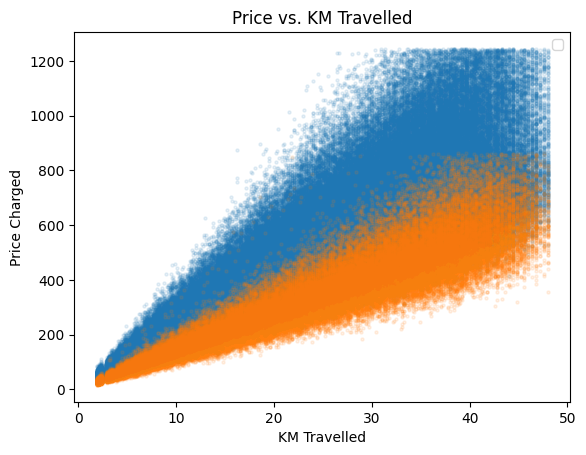

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


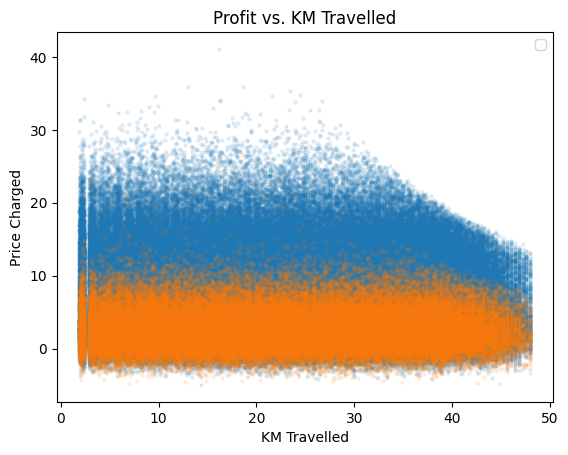

In [8]:
# Useful Plots
print("\n\nUseful Plots")
#1.1 Price vs. KM Travelled:
plt.scatter(yellow_cab_data["KM Travelled"], yellow_cab_data["Price Charged"], s = 5, alpha = .1)
plt.scatter(pink_cab_data["KM Travelled"], pink_cab_data["Price Charged"], s = 5, alpha = .1)
plt.xlabel("KM Travelled")
plt.ylabel("Price Charged")
plt.legend()
plt.title("Price vs. KM Travelled")
plt.show()

#1.2 profit vs. KM Travelled:
plt.scatter(yellow_cab_data["KM Travelled"], yellow_cab_data["Profit_per_KM"], s = 5, alpha = .1)
plt.scatter(pink_cab_data["KM Travelled"], pink_cab_data["Profit_per_KM"], s = 5, alpha = .1)
plt.xlabel("KM Travelled")
plt.ylabel("Price Charged")
plt.legend()
plt.title("Profit vs. KM Travelled")
plt.show()

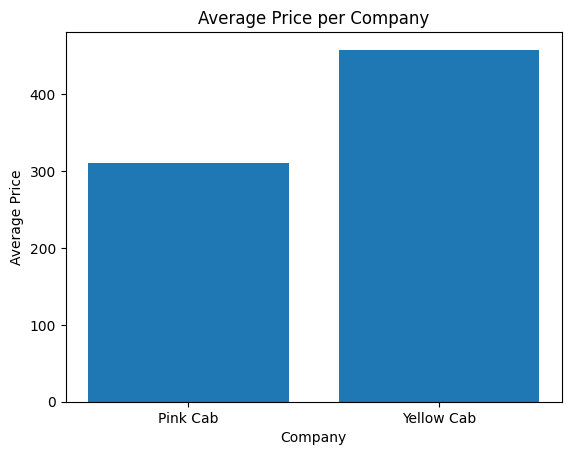

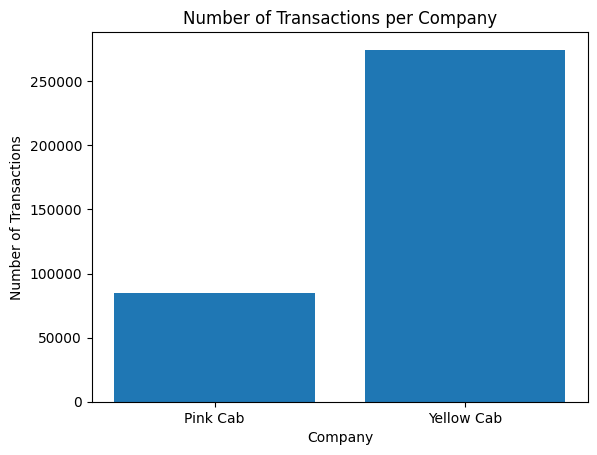

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


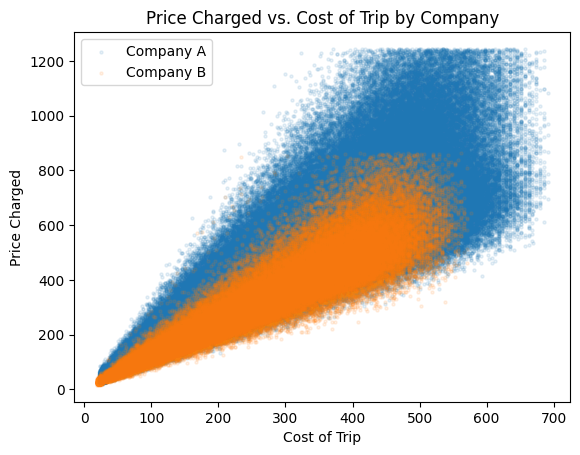

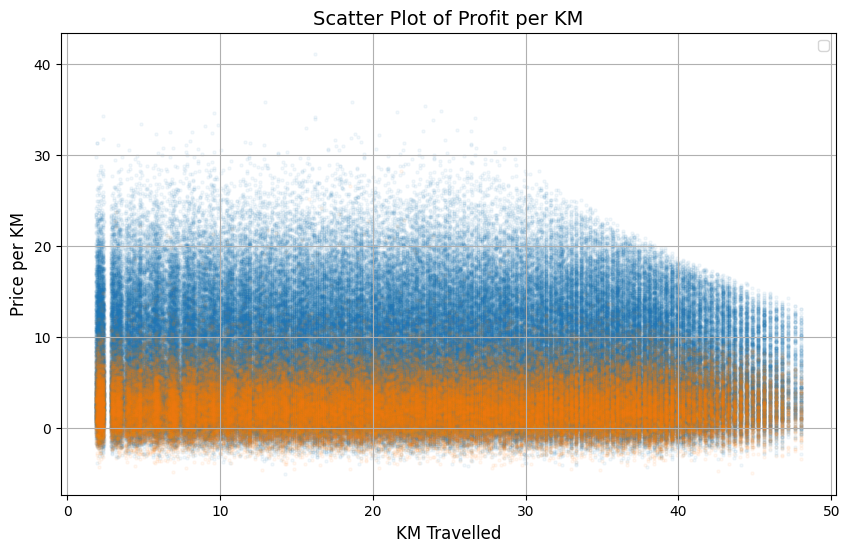

In [9]:
#2.1 average Price for each company:
avg_price_per_company = Cab_Data.groupby("Company")["Price Charged"].mean()
num_transactions_per_company = Cab_Data.groupby("Company")["Transaction ID"].count()

plt.bar(avg_price_per_company.index, avg_price_per_company.values)
plt.xlabel("Company")
plt.ylabel("Average Price")
plt.title("Average Price per Company")
plt.show()

#2.2 number of transactions per company
plt.bar(num_transactions_per_company.index, num_transactions_per_company.values)
plt.xlabel("Company")
plt.ylabel("Number of Transactions")
plt.title("Number of Transactions per Company")
plt.show()

#2.3 price charged vs KM travelled
yellow_cab_data = yellow_cab_data.sort_values(by="Cost of Trip")
pink_cab_data = pink_cab_data.sort_values(by="Cost of Trip")

plt.scatter(yellow_cab_data["Cost of Trip"], yellow_cab_data["Price Charged"], label="Company A", s = 5, alpha = .1)
plt.scatter(pink_cab_data["Cost of Trip"], pink_cab_data["Price Charged"], label="Company B", s = 5, alpha = .1)

plt.xlabel("Cost of Trip")
plt.ylabel("Price Charged")
plt.title("Price Charged vs. Cost of Trip by Company")
plt.legend()

#2.4 Profit per KM travelled
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter( x = yellow_cab_data["KM Travelled"] ,y = yellow_cab_data["Profit_per_KM"], s = 5, alpha = .05)
plt.scatter( x = pink_cab_data["KM Travelled"] ,y = pink_cab_data["Profit_per_KM"], s = 5, alpha = .05)

plt.xlabel("KM Travelled", fontsize=12)
plt.ylabel("Price per KM", fontsize=12)
plt.title("Scatter Plot of Profit per KM", fontsize=14)
plt.legend()

plt.grid(True)
plt.show()

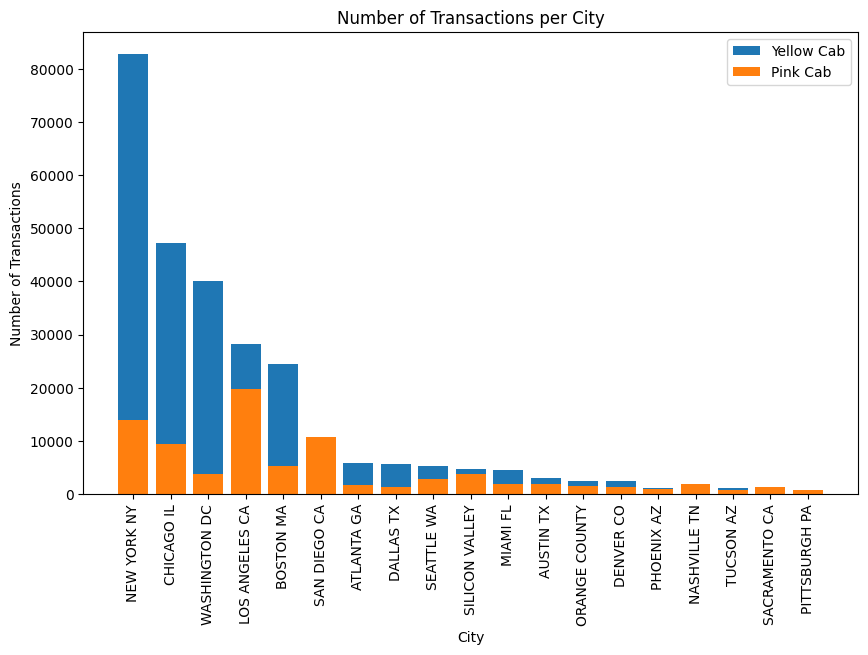

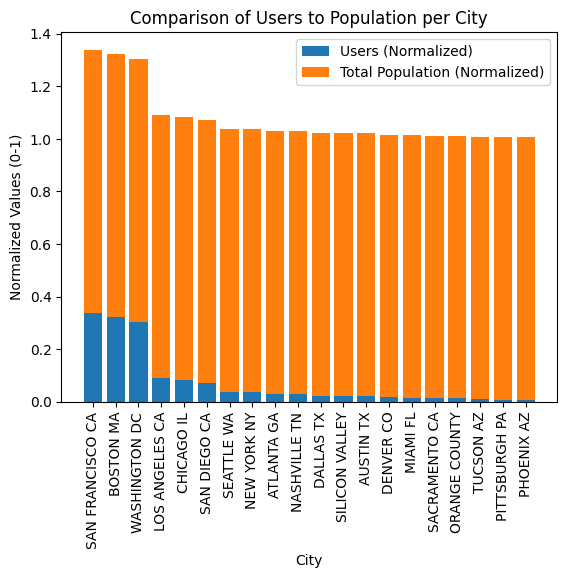

In [10]:
#3. City Demand per Company:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(yellow_cab_data["City"].value_counts().index, yellow_cab_data["City"].value_counts().values, label="Yellow Cab") 
plt.bar(pink_cab_data["City"].value_counts().index, pink_cab_data["City"].value_counts().values, label="Pink Cab")
plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Number of Transactions")
plt.title("Number of Transactions per City")
plt.legend()
plt.show()

plt.bar(City["City"], City["Users"] / City["Population"], label="Users (Normalized)")
plt.bar(City["City"], 1, bottom=City["Users"] / City["Population"], label="Total Population (Normalized)")
plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Normalized Values (0-1)")
plt.title("Comparison of Users to Population per City")
plt.legend()
plt.show()



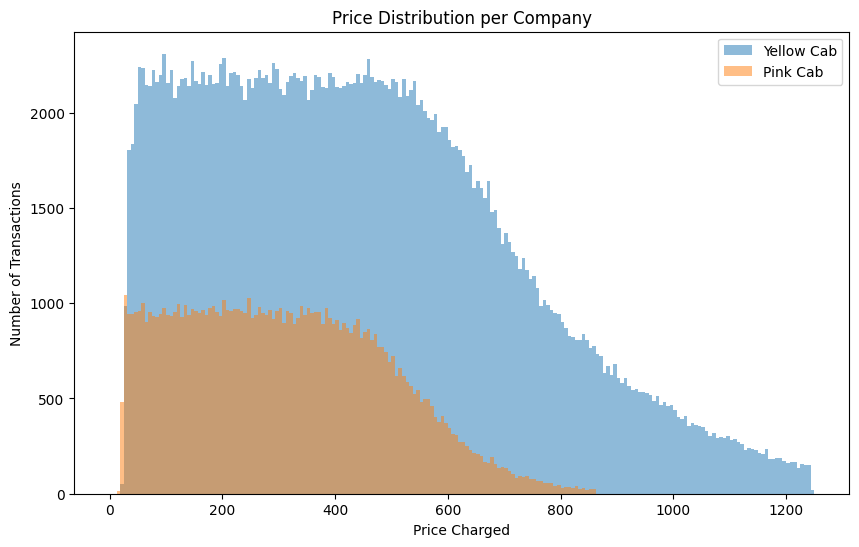

In [11]:
#4. Price Distribution per Company:
plt.figure(figsize=(10, 6))
plt.hist(yellow_cab_data["Price Charged"], bins=200, label="Yellow Cab", range=(0, 1250), alpha=0.5)
plt.hist(pink_cab_data["Price Charged"], bins=200, label="Pink Cab", range=(0, 1250), alpha=0.5)

plt.xlabel("Price Charged")
plt.ylabel("Number of Transactions")
plt.title("Price Distribution per Company")
plt.legend()
plt.show()

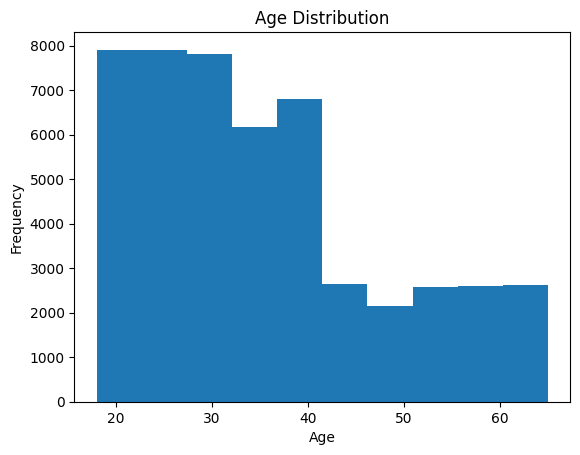

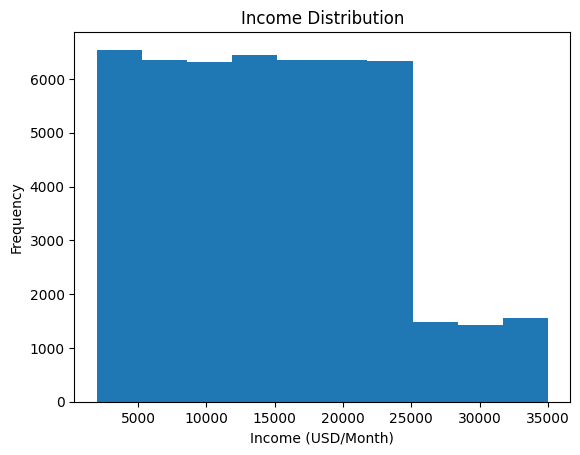

C:\Users\ahmed\AppData\Local\Temp\ipykernel_15320\3597621275.py:19: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  yellow_cab_data["Year"] = pd.to_datetime(yellow_cab_data["Date of Travel"]).dt.year
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15320\3597621275.py:20: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pink_cab_data["Year"] = pd.to_datetime(pink_cab_data["Date of Travel"]).dt.year


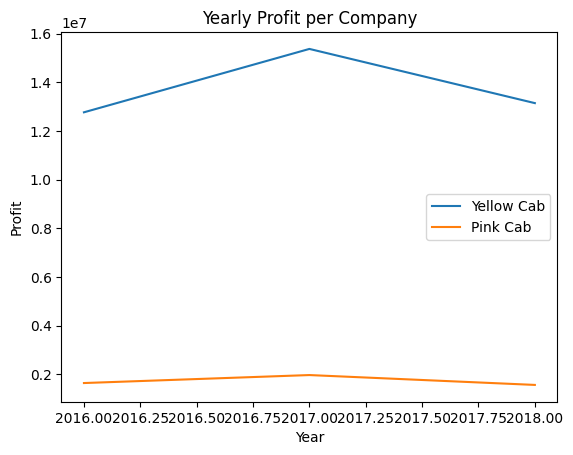

C:\Users\ahmed\AppData\Local\Temp\ipykernel_15320\3597621275.py:34: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  yellow_cab_data["Month of Travel"] = pd.to_datetime(yellow_cab_data["Date of Travel"]).dt.month
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15320\3597621275.py:35: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pink_cab_data["Month of Travel"] = pd.to_datetime(pink_cab_data["Date of Travel"]).dt.month


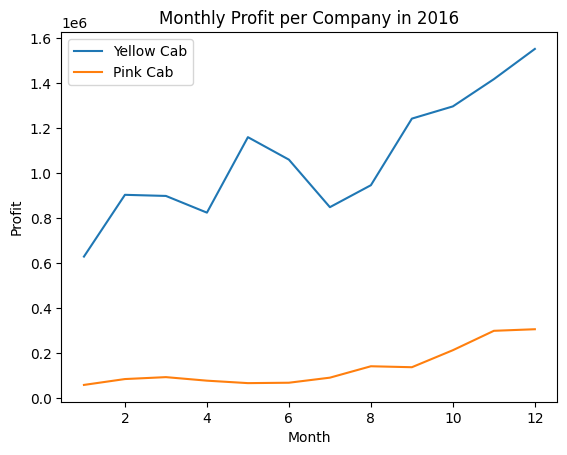

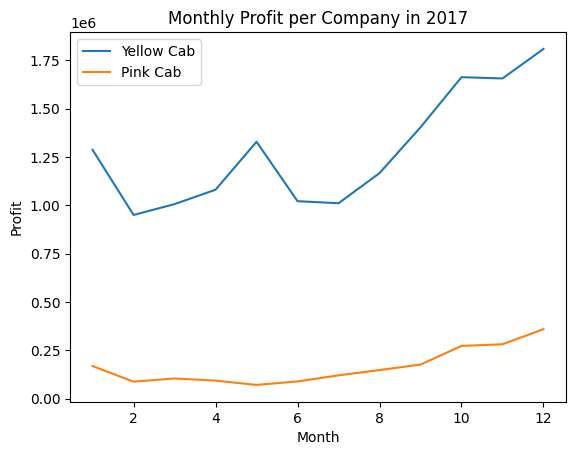

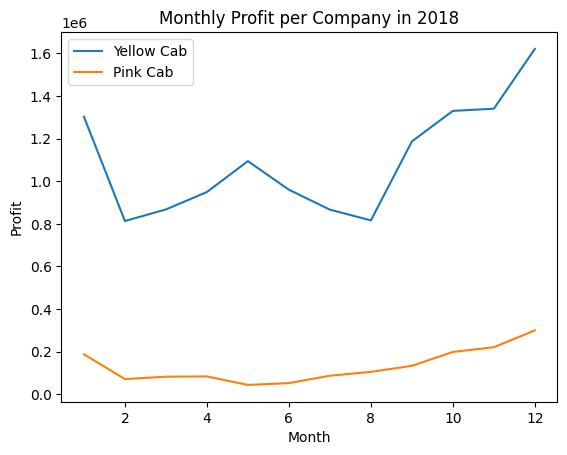

In [12]:
#5. Customer Segmentation Analysis
merged_data = Cab_Data.merge(Transaction_ID, on="Transaction ID")
merged_data = merged_data.merge(Customer_ID, on= "Customer ID")

#5.1 Age
plt.hist(Customer_ID["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")
plt.show()
#5.2 Income
plt.hist(Customer_ID["Income (USD/Month)"])
plt.xlabel("Income (USD/Month)")
plt.ylabel("Frequency")
plt.title("Income Distribution")
plt.show()

#5.3 yearly and monthly profit plot for each company
yellow_cab_data["Year"] = pd.to_datetime(yellow_cab_data["Date of Travel"]).dt.year
pink_cab_data["Year"] = pd.to_datetime(pink_cab_data["Date of Travel"]).dt.year

yellow_cab_data = yellow_cab_data[(yellow_cab_data["Year"] == 2016) | (yellow_cab_data["Year"] == 2017) | (yellow_cab_data["Year"] == 2018)]
pink_cab_data = pink_cab_data[(pink_cab_data["Year"] == 2016) | (pink_cab_data["Year"] == 2017) | (pink_cab_data["Year"] == 2018)]

yellow_cab_data.groupby("Year")["Profit"].sum().plot(label="Yellow Cab")
pink_cab_data.groupby("Year")["Profit"].sum().plot(label="Pink Cab")
plt.xlabel("Year")
plt.ylabel("Profit")
plt.title("Yearly Profit per Company")
plt.legend()
plt.show()

#create month of travel column
yellow_cab_data["Month of Travel"] = pd.to_datetime(yellow_cab_data["Date of Travel"]).dt.month
pink_cab_data["Month of Travel"] = pd.to_datetime(pink_cab_data["Date of Travel"]).dt.month

#plot monthly profit for each company in each year
yellow_cab_data[yellow_cab_data["Year"] == 2016].groupby("Month of Travel")["Profit"].sum().plot(label="Yellow Cab")
pink_cab_data[pink_cab_data["Year"] == 2016].groupby("Month of Travel")["Profit"].sum().plot(label="Pink Cab")
plt.xlabel("Month")
plt.ylabel("Profit")
plt.title("Monthly Profit per Company in 2016")
plt.legend()
plt.show()

yellow_cab_data[yellow_cab_data["Year"] == 2017].groupby("Month of Travel")["Profit"].sum().plot(label="Yellow Cab")
pink_cab_data[pink_cab_data["Year"] == 2017].groupby("Month of Travel")["Profit"].sum().plot(label="Pink Cab")
plt.xlabel("Month")
plt.ylabel("Profit")
plt.title("Monthly Profit per Company in 2017")
plt.legend()
plt.show()

yellow_cab_data[yellow_cab_data["Year"] == 2018].groupby("Month of Travel")["Profit"].sum().plot(label="Yellow Cab")
pink_cab_data[pink_cab_data["Year"] == 2018].groupby("Month of Travel")["Profit"].sum().plot(label="Pink Cab")
plt.xlabel("Month")
plt.ylabel("Profit")
plt.title("Monthly Profit per Company in 2018")
plt.legend()
plt.show()


Analyis results and hypothesis

1.1 Price vs. KM Travelled:
   - The price charged increases with the distance travelled 
   - The price charged is higher for Yellow Cab than Pink Cab 
   - The Average price charged, Number of transactions per city, and profit per KM for Yellow Cab is higher than Pink Cab

1.2 Price distribution:
   - Yellow Cab has a higher price distribution than Pink Cab
   - The price distribution for both companies drops after ~$450 USD

1.3 Yearly profit:
   - Yearly profit for both companies peaked in 2017
   - Yearly profit for Yellow Cab is higher than Pink Cab in all 3 years

1.4 Monthly profit:
   - Monthly profit for Yellow Cab is higher than Pink Cab in all 3 years
   - Monthly profit for Yellow Cab experiences increases and decreases throughout the year, indicating seasonality and smart pricing/offers

Verdict
   - Yellow Cab is more profitable than Pink Cab, and features a more intelligent pricing strategy, as well as a higher number of transactions and profits
   - therfore, the company should focus on investing in Yellow Cab
   - Yellow Cab should focus on increasing the number of transactions in Chicago and New York City